# Support Vector Machine Regression for Time Series Analysis

## Notebook Setup

In [1]:
# Imports to setup the notebook
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from numpy.lib.stride_tricks import sliding_window_view
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVR
from skopt import BayesSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import make_scorer, mean_squared_error, mean_absolute_error
from IPython.display import display, HTML

show_html = lambda html: display(HTML(html))

pd.set_option('display.max_columns', None)

## Import and basic review of data

In [2]:
# Read to dataset into a Pandas dataframe and review head to confirm import
df_base = pd.read_csv('../Data/Energy.csv', index_col=0)
df_base.head()

,date,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,RH_4,T5,RH_5,T6,RH_6,T7,RH_7,T8,RH_8,T9,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,rv1,rv2
0,11-01-2016 17:00,60,30,19.89,47.596667,19.2,44.790000,19.79,44.730000,19.000000,45.566667,17.166667,55.20,7.026667,84.256667,17.200000,41.626667,18.2,48.900000,17.033333,45.53,6.60,733.5,92.0,7.000000,63.000000,5.3,13.275433,13.275433
1,11-01-2016 17:10,60,30,19.89,46.693333,19.2,44.722500,19.79,44.790000,19.000000,45.992500,17.166667,55.20,6.833333,84.063333,17.200000,41.560000,18.2,48.863333,17.066667,45.56,6.48,733.6,92.0,6.666667,59.166667,5.2,18.606195,18.606195
2,11-01-2016 17:20,50,30,19.89,46.300000,19.2,44.626667,19.79,44.933333,18.926667,45.890000,17.166667,55.09,6.560000,83.156667,17.200000,41.433333,18.2,48.730000,17.000000,45.50,6.37,733.7,92.0,6.333333,55.333333,5.1,28.642668,28.642668
3,11-01-2016 17:30,50,40,19.89,46.066667,19.2,44.590000,19.79,45.000000,18.890000,45.723333,17.166667,55.09,6.433333,83.423333,17.133333,41.290000,18.1,48.590000,17.000000,45.40,6.25,733.8,92.0,6.000000,51.500000,5.0,45.410390,45.410390
4,11-01-2016 17:40,60,40,19.89,46.333333,19.2,44.530000,19.79,45.000000,18.890000,45.530000,17.200000,55.09,6.366667,84.893333,17.200000,41.230000,18.1,48.590000,17.000000,45.40,6.13,733.9,92.0,5.666667,47.666667,4.9,10.084097,10.084097


In [3]:
df_base.shape

(19735, 29)

In [4]:
df_base.info()

<class 'pandas.core.frame.DataFrame'>
Index: 19735 entries, 0 to 19734
Data columns (total 29 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   date         19735 non-null  object 
 1   Appliances   19735 non-null  int64  
 2   lights       19735 non-null  int64  
 3   T1           19735 non-null  float64
 4   RH_1         19735 non-null  float64
 5   T2           19735 non-null  float64
 6   RH_2         19735 non-null  float64
 7   T3           19735 non-null  float64
 8   RH_3         19735 non-null  float64
 9   T4           19735 non-null  float64
 10  RH_4         19735 non-null  float64
 11  T5           19735 non-null  float64
 12  RH_5         19735 non-null  float64
 13  T6           19735 non-null  float64
 14  RH_6         19735 non-null  float64
 15  T7           19735 non-null  float64
 16  RH_7         19735 non-null  float64
 17  T8           19735 non-null  float64
 18  RH_8         19735 non-null  float64
 19  T9       

In [5]:
df_base.describe().T

,count,mean,std,min,25%,50%,75%,max
Appliances,19735.0,97.694958,102.524891,10.000000,50.000000,60.000000,100.000000,1080.000000
lights,19735.0,3.801875,7.935988,0.000000,0.000000,0.000000,0.000000,70.000000
T1,19735.0,21.686571,1.606066,16.790000,20.760000,21.600000,22.600000,26.260000
RH_1,19735.0,40.259739,3.979299,27.023333,37.333333,39.656667,43.066667,63.360000
T2,19735.0,20.341219,2.192974,16.100000,18.790000,20.000000,21.500000,29.856667
RH_2,19735.0,40.420420,4.069813,20.463333,37.900000,40.500000,43.260000,56.026667
T3,19735.0,22.267611,2.006111,17.200000,20.790000,22.100000,23.290000,29.236000
RH_3,19735.0,39.242500,3.254576,28.766667,36.900000,38.530000,41.760000,50.163333
T4,19735.0,20.855335,2.042884,15.100000,19.530000,20.666667,22.100000,26.200000
RH_4,19735.0,39.026904,4.341321,27.660000,35.530000,38.400000,42.156667,51.090000


## Data Preparation

In [6]:
# split of target variable
energy = df_base.loc[:, 'Appliances']

In [7]:
e_train, e_test = energy.iloc[:12000], energy.iloc[12000:] 

In [8]:
e_train.shape, e_test.shape

((12000,), (7735,))

### Sliding Window Setup

In [9]:
w = 4

# Normalization
scaler = MinMaxScaler()
e_train_s = scaler.fit_transform(e_train.to_numpy().reshape(-1,1))
e_test_s = scaler.transform(e_test.to_numpy().reshape(-1,1))

# Defining Windows
# X = information used to make predictions. 
# y = real energy consumption to be predicted. 
windows_train = sliding_window_view(e_train_s, w+1, axis=0).copy()
X_train_w, y_train_w = windows_train.squeeze()[:,:-1], windows_train.squeeze()[:,-1]

windows_test = sliding_window_view(e_test_s, w+1, axis=0).copy()
X_test_w, y_test_w = windows_test.squeeze()[:,:-1], windows_test.squeeze()[:,-1]


In [10]:
X_train_w.shape, X_test_w.shape, y_train_w.shape, y_test_w.shape

((11996, 4), (7731, 4), (11996,), (7731,))

## Support Vector Machines
## Linear Kernel

In [11]:
%%time
param = {'C':10**np.linspace(-3,3,101), 'epsilon':np.linspace(0,0.1,21)}

lsvr = SVR(kernel='linear',max_iter=25000,cache_size=2000)

lsvr_search = BayesSearchCV(lsvr,param,n_iter=25,cv=TimeSeriesSplit(n_splits=5,gap=w+1), 
                            scoring=make_scorer(mean_squared_error,greater_is_better=False),n_jobs=-1,refit=True,random_state=11)
lsvr_search.fit(X_train_w,y_train_w)


CPU times: total: 2min 56s
Wall time: 1min 53s


BayesSearchCV(cv=TimeSeriesSplit(gap=5, max_train_size=None, n_splits=5, test_size=None),
              estimator=SVR(cache_size=2000, kernel='linear', max_iter=25000),
              n_iter=25, n_jobs=-1, random_state=11,
              scoring=make_scorer(mean_squared_error, greater_is_better=False, response_method='predict'),
              search_spaces={'C': array([1.00000000e-03, 1.14815362e-03, 1.31825674e-03, 1.513...
       1.09647820e+02, 1.25892541e+02, 1.44543977e+02, 1.65958691e+02,
       1.90546072e+02, 2.18776162e+02, 2.51188643e+02, 2.88403150e+02,
       3.31131121e+02, 3.80189396e+02, 4.36515832e+02, 5.01187234e+02,
       5.75439937e+02, 6.60693448e+02, 7.58577575e+02, 8.70963590e+02,
       1.00000000e+03]),
                             'epsilon': array([0.   , 0.005, 0.01 , 0.015, 0.02 , 0.025, 0.03 , 0.035, 0.04 ,
       0.045, 0.05 , 0.055, 0.06 , 0.065, 0.07 , 0.075, 0.08 , 0.085,
       0.09 , 0.095, 0.1  ])})

In [12]:
show_html(pd.DataFrame(lsvr_search.cv_results_).loc[:,['params','mean_test_score','rank_test_score']].sort_values(by='rank_test_score').head(5).to_html())

,params,mean_test_score,rank_test_score
11,"{'C': 0.12589254117941676, 'epsilon': 0.03}",-0.003863,1
4,"{'C': 15.848931924611142, 'epsilon': 0.03}",-0.003877,2
6,"{'C': 1.0, 'epsilon': 0.03}",-0.003878,3
1,"{'C': 9.120108393559097, 'epsilon': 0.035}",-0.003909,4
2,"{'C': 13.803842646028839, 'epsilon': 0.035}",-0.003917,5


### Model Evaluation - Linear Kernal

In [13]:
MSE = mean_squared_error(y_test_w, lsvr_search.predict(X_test_w))
MAE = mean_absolute_error(y_test_w, lsvr_search.predict(X_test_w))
RMSE = np.sqrt(MSE)
print(f"The Mean Squared Error is {MSE:.5f}")
print(f"The Root MSE is {RMSE:.5f}")
print(f"The Mean Absolute error is {MAE:.5f}")

The Mean Squared Error is 0.00362
The Root MSE is 0.06014
The Mean Absolute error is 0.02686


### Prediction vs True Values

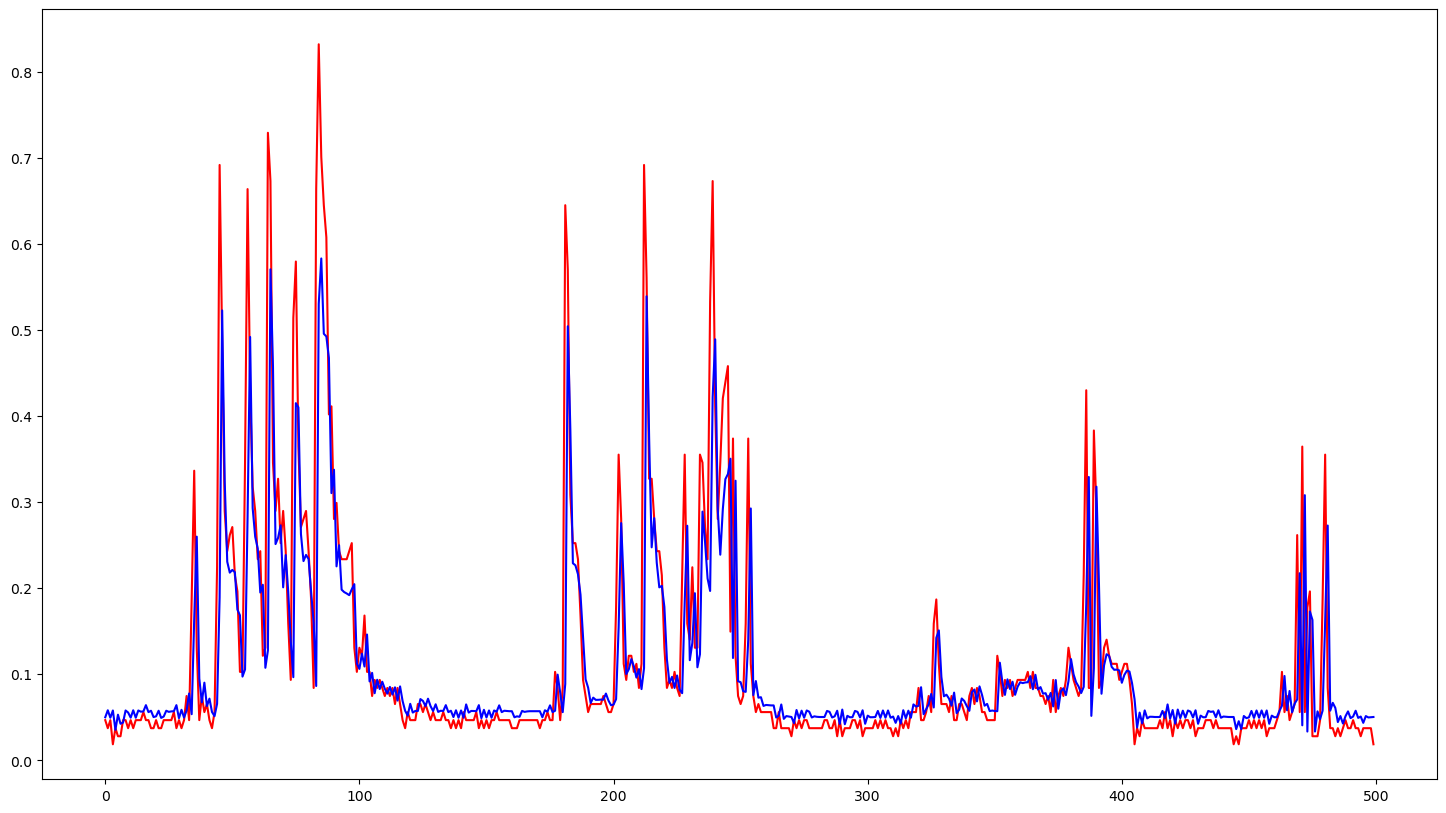

In [14]:
plt.figure(figsize=(18,10))
plt.plot(y_test_w[:500],'red')
plt.plot(lsvr_search.predict(X_test_w[:500,:]), 'b');

## Polynomial Kernel

In [15]:
%%time
param = {'C':10**np.linspace(-3,3,101), 'epsilon':np.linspace(0,0.1,21), 'degree':[2,3,4]}

psvr = SVR(kernel='poly',max_iter=25000,cache_size=2000)

psvr_search = BayesSearchCV(psvr,param,n_iter=25,cv=TimeSeriesSplit(n_splits=5,gap=w+1), 
                            scoring=make_scorer(mean_squared_error,greater_is_better=False),n_jobs=-1,refit=True,random_state=0)
psvr_search.fit(X_train_w,y_train_w)


CPU times: total: 2min 3s
Wall time: 2min 24s


C:\Users\cmurr\anaconda3\Lib\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=25000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


BayesSearchCV(cv=TimeSeriesSplit(gap=5, max_train_size=None, n_splits=5, test_size=None),
              estimator=SVR(cache_size=2000, kernel='poly', max_iter=25000),
              n_iter=25, n_jobs=-1, random_state=0,
              scoring=make_scorer(mean_squared_error, greater_is_better=False, response_method='predict'),
              search_spaces={'C': array([1.00000000e-03, 1.14815362e-03, 1.31825674e-03, 1.513561...
       1.09647820e+02, 1.25892541e+02, 1.44543977e+02, 1.65958691e+02,
       1.90546072e+02, 2.18776162e+02, 2.51188643e+02, 2.88403150e+02,
       3.31131121e+02, 3.80189396e+02, 4.36515832e+02, 5.01187234e+02,
       5.75439937e+02, 6.60693448e+02, 7.58577575e+02, 8.70963590e+02,
       1.00000000e+03]),
                             'degree': [2, 3, 4],
                             'epsilon': array([0.   , 0.005, 0.01 , 0.015, 0.02 , 0.025, 0.03 , 0.035, 0.04 ,
       0.045, 0.05 , 0.055, 0.06 , 0.065, 0.07 , 0.075, 0.08 , 0.085,
       0.09 , 0.095, 0.1  ])})

In [16]:
show_html(pd.DataFrame(psvr_search.cv_results_).loc[:,['params','mean_test_score','rank_test_score']].sort_values(by='rank_test_score').head(5).to_html())

,params,mean_test_score,rank_test_score
11,"{'C': 0.023988329190194897, 'degree': 2, 'epsilon': 0.045}",-0.004752,1
10,"{'C': 0.006918309709189363, 'degree': 2, 'epsilon': 0.045}",-0.004761,2
17,"{'C': 0.0034673685045253167, 'degree': 2, 'epsilon': 0.045}",-0.004762,3
18,"{'C': 0.006918309709189363, 'degree': 2, 'epsilon': 0.025}",-0.004769,4
20,"{'C': 0.0034673685045253167, 'degree': 2, 'epsilon': 0.025}",-0.004770,5


### Model Evaluation - Polynomial Kernal

In [17]:
MSE = mean_squared_error(y_test_w, psvr_search.predict(X_test_w))
MAE = mean_absolute_error(y_test_w, psvr_search.predict(X_test_w))
RMSE = np.sqrt(MSE)
print(f"The Mean Squared Error is {MSE:.5f}")
print(f"The Root MSE is {RMSE:.5f}")
print(f"The Mean Absolute error is {MAE:.5f}")

The Mean Squared Error is 0.00429
The Root MSE is 0.06551
The Mean Absolute error is 0.03401


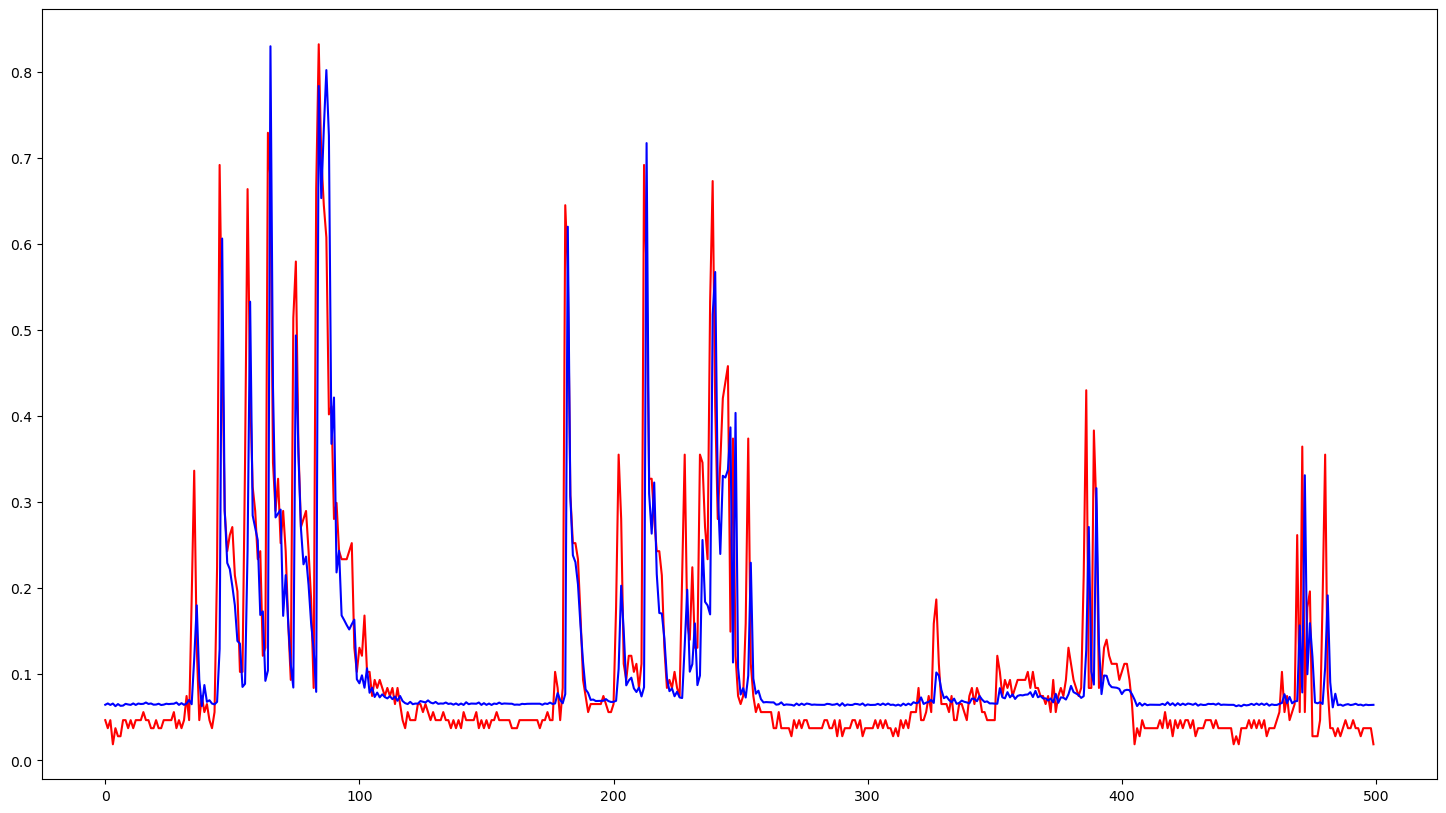

In [18]:
plt.figure(figsize=(18,10))
plt.plot(y_test_w[:500],'red')
plt.plot(psvr_search.predict(X_test_w[:500,:]), 'b');

## Radial Basis Function (RBF) Kernel

In [19]:
%%time
param = {'C':10**np.linspace(-3,3,101), 'epsilon':np.linspace(0,0.1,11), 'gamma':['auto', 'scale']}

rbfsvr = SVR(kernel='rbf',max_iter=25000,cache_size=2000)

rbfsvr_search = BayesSearchCV(rbfsvr,param,n_iter=15,cv=TimeSeriesSplit(n_splits=5,gap=w+1), 
                            scoring=make_scorer(mean_squared_error,greater_is_better=False),n_jobs=-1,refit=True,random_state=0)

rbfsvr_search.fit(X_train_w,y_train_w)

CPU times: total: 26.1 s
Wall time: 58.2 s


BayesSearchCV(cv=TimeSeriesSplit(gap=5, max_train_size=None, n_splits=5, test_size=None),
              estimator=SVR(cache_size=2000, max_iter=25000), n_iter=15,
              n_jobs=-1, random_state=0,
              scoring=make_scorer(mean_squared_error, greater_is_better=False, response_method='predict'),
              search_spaces={'C': array([1.00000000e-03, 1.14815362e-03, 1.31825674e-03, 1.51356125e-03,
       1.73780...
       1.09647820e+02, 1.25892541e+02, 1.44543977e+02, 1.65958691e+02,
       1.90546072e+02, 2.18776162e+02, 2.51188643e+02, 2.88403150e+02,
       3.31131121e+02, 3.80189396e+02, 4.36515832e+02, 5.01187234e+02,
       5.75439937e+02, 6.60693448e+02, 7.58577575e+02, 8.70963590e+02,
       1.00000000e+03]),
                             'epsilon': array([0.  , 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 ]),
                             'gamma': ['auto', 'scale']})

In [20]:
show_html(pd.DataFrame(rbfsvr_search.cv_results_).loc[:,['params','mean_test_score','rank_test_score']].sort_values(by='rank_test_score').head(5).to_html())

,params,mean_test_score,rank_test_score
4,"{'C': 0.023988329190194897, 'epsilon': 0.02, 'gamma': 'scale'}",-0.003685,1
11,"{'C': 54.954087385762485, 'epsilon': 0.03, 'gamma': 'auto'}",-0.003805,2
2,"{'C': 1.513561248436207, 'epsilon': 0.0, 'gamma': 'auto'}",-0.003858,3
9,"{'C': 0.16595869074375597, 'epsilon': 0.04, 'gamma': 'auto'}",-0.003964,4
14,"{'C': 0.0060255958607435805, 'epsilon': 0.03, 'gamma': 'scale'}",-0.004007,5


In [21]:
MSE = mean_squared_error(y_test_w, rbfsvr_search.predict(X_test_w))
MAE = mean_absolute_error(y_test_w, rbfsvr_search.predict(X_test_w))
RMSE = np.sqrt(MSE)
print(f"The Mean Squared Error is {MSE:.5f}")
print(f"The Root MSE is {RMSE:.5f}")
print(f"The Mean Absolute error is {MAE:.5f}")

The Mean Squared Error is 0.00355
The Root MSE is 0.05959
The Mean Absolute error is 0.02340


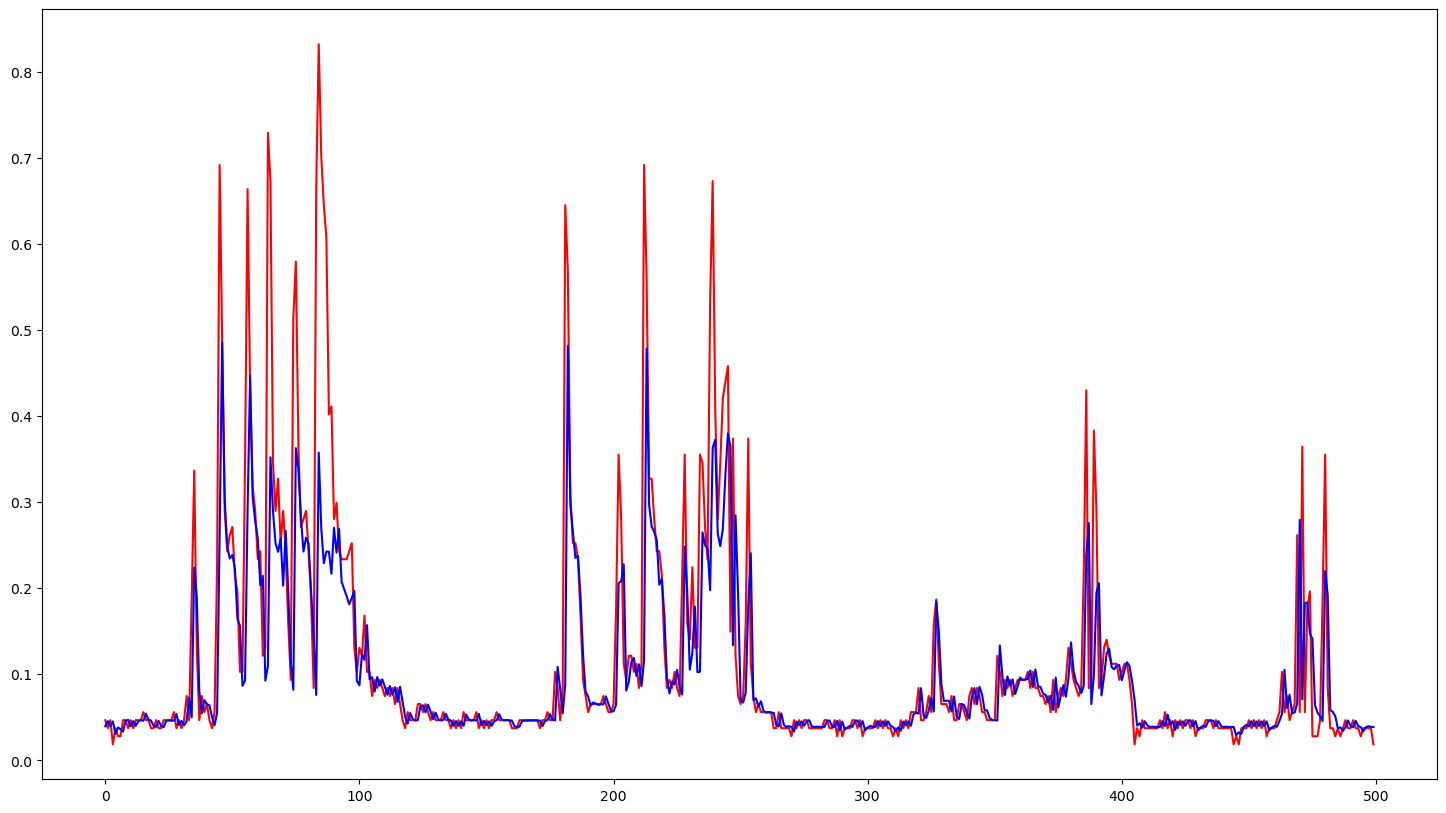

In [22]:
plt.figure(figsize=(18,10))
plt.plot(y_test_w[:500],'red')
plt.plot(rbfsvr_search.predict(X_test_w[:500,:]), 'b');

## Bayes Grid Search on all Parameters
Not part of the course

In [23]:
%%time
param = {'kernel': ['linear', 'poly', 'rbf'], 'C':10**np.linspace(-3,3,101), 'epsilon':np.linspace(0,0.1,11), 'gamma':['auto', 'scale'], 'degree':[2,3,4]}

allsvr = SVR(max_iter=25000,cache_size=2000)

allsvr_search = BayesSearchCV(allsvr,param,n_iter=15,cv=TimeSeriesSplit(n_splits=5,gap=w+1), 
                            scoring=make_scorer(mean_squared_error,greater_is_better=False),n_jobs=-1,refit=True,random_state=0)

allsvr_search.fit(X_train_w,y_train_w)

CPU times: total: 28.5 s
Wall time: 46.7 s


BayesSearchCV(cv=TimeSeriesSplit(gap=5, max_train_size=None, n_splits=5, test_size=None),
              estimator=SVR(cache_size=2000, max_iter=25000), n_iter=15,
              n_jobs=-1, random_state=0,
              scoring=make_scorer(mean_squared_error, greater_is_better=False, response_method='predict'),
              search_spaces={'C': array([1.00000000e-03, 1.14815362e-03, 1.31825674e-03, 1.51356125e-03,
       1.73780...
       1.09647820e+02, 1.25892541e+02, 1.44543977e+02, 1.65958691e+02,
       1.90546072e+02, 2.18776162e+02, 2.51188643e+02, 2.88403150e+02,
       3.31131121e+02, 3.80189396e+02, 4.36515832e+02, 5.01187234e+02,
       5.75439937e+02, 6.60693448e+02, 7.58577575e+02, 8.70963590e+02,
       1.00000000e+03]),
                             'degree': [2, 3, 4],
                             'epsilon': array([0.  , 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 ]),
                             'gamma': ['auto', 'scale'],
                             'kernel': ['linear', 'poly', 'rbf']})

In [24]:
show_html(pd.DataFrame(rbfsvr_search.cv_results_).loc[:,['params','mean_test_score','rank_test_score']].sort_values(by='rank_test_score').head(5).to_html())

,params,mean_test_score,rank_test_score
4,"{'C': 0.023988329190194897, 'epsilon': 0.02, 'gamma': 'scale'}",-0.003685,1
11,"{'C': 54.954087385762485, 'epsilon': 0.03, 'gamma': 'auto'}",-0.003805,2
2,"{'C': 1.513561248436207, 'epsilon': 0.0, 'gamma': 'auto'}",-0.003858,3
9,"{'C': 0.16595869074375597, 'epsilon': 0.04, 'gamma': 'auto'}",-0.003964,4
14,"{'C': 0.0060255958607435805, 'epsilon': 0.03, 'gamma': 'scale'}",-0.004007,5


In [25]:
MSE = mean_squared_error(y_test_w, allsvr_search.predict(X_test_w))
MAE = mean_absolute_error(y_test_w, allsvr_search.predict(X_test_w))
RMSE = np.sqrt(MSE)
print(f"The Mean Squared Error is {MSE:.5f}")
print(f"The Root MSE is {RMSE:.5f}")
print(f"The Mean Absolute error is {MAE:.5f}")

The Mean Squared Error is 0.00364
The Root MSE is 0.06033
The Mean Absolute error is 0.02469


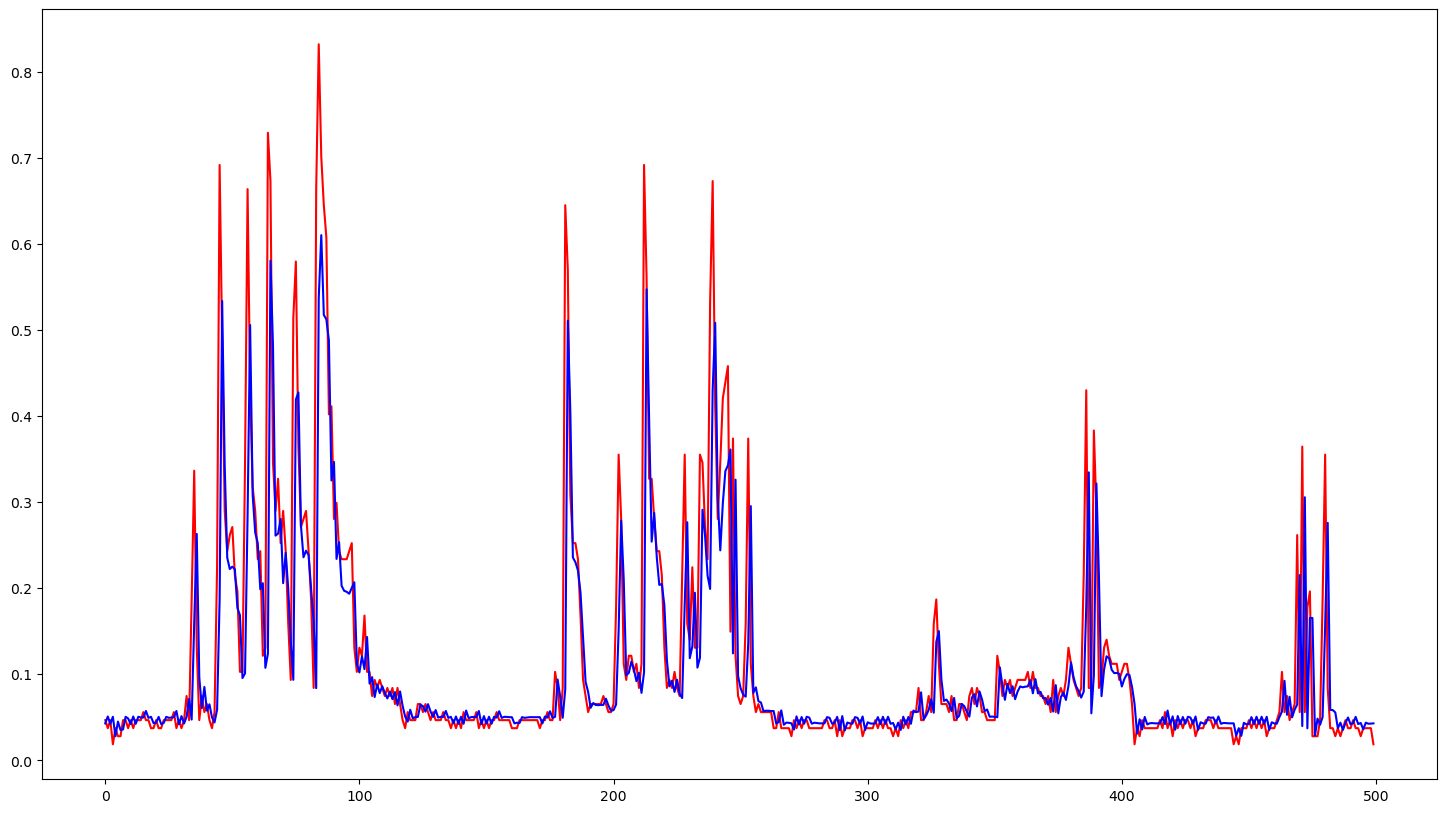

In [26]:
plt.figure(figsize=(18,10))
plt.plot(y_test_w[:500],'red')
plt.plot(allsvr_search.predict(X_test_w[:500,:]), 'b');

When just run indididully the rbf performed slightly better than the rbf kernel. When kernel is include in the search linear does better
but still not as well as rbf. I need to try this on Grid Search